<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_8_model_new_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier,Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [4]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [5]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [6]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [7]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [8]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [9]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [10]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [11]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [ ]:
df1 = df1.assign(**feature_dict)

In [13]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [14]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [15]:
N_SPLITS = 7
current_feat = list(X.columns[:8])

In [16]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

In [18]:
def calc_log_loss_weight(y_true):
    y_true = y_true.astype(int)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [19]:
def plot(scores,best_score,text):
  plt.figure(figsize=(20,5))
  plt.plot(thresholds,scores,'-o',color='blue')
  plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
  plt.xlabel('Threshold',size=14)
  plt.ylabel(f'Validation {i}',size=14)
  plt.title(f'Threshold vs. {i} with Best {i}= {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
  plt.show()

In [20]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=22)
indx_all = X_train.index

oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)

models=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print('#'*25)
    print('### CV_Fold',idx+1)
    print('#'*25)

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]


    train_pool = Pool(X_train_сv[columns], y_train_сv, feature_names=columns)
    test_pool = Pool(X_val_сv[columns], y_val_сv, feature_names=columns)

    clf = CatBoostClassifier()
    clf.fit(train_pool,
            eval_set=test_pool,
            verbose=0)
    models.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val_сv, y_pred)
    print("AUC_ROC----"+str(roc_auc_score(y_val_сv, y_pred)))
    print("F1-score-----"+str(f1_score(y_val_сv, y_pred_metki,average='macro')))

#########################
### CV_Fold 1
#########################
AUC_ROC----0.7614302932904781
F1-score-----0.6761054340559641
#########################
### CV_Fold 2
#########################
AUC_ROC----0.7396143029329048
F1-score-----0.6573165529010239
#########################
### CV_Fold 3
#########################
AUC_ROC----0.7123614594288489
F1-score-----0.6747513050329952
#########################
### CV_Fold 4
#########################
AUC_ROC----0.7981959388398997
F1-score-----0.6862723255727601
#########################
### CV_Fold 5
#########################
AUC_ROC----0.7771620419059947
F1-score-----0.6784611425630468
#########################
### CV_Fold 6
#########################
AUC_ROC----0.7137607601104433
F1-score-----0.6491965681701725
#########################
### CV_Fold 7
#########################
AUC_ROC----0.7598465161604678
F1-score-----0.6329896907216495


0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

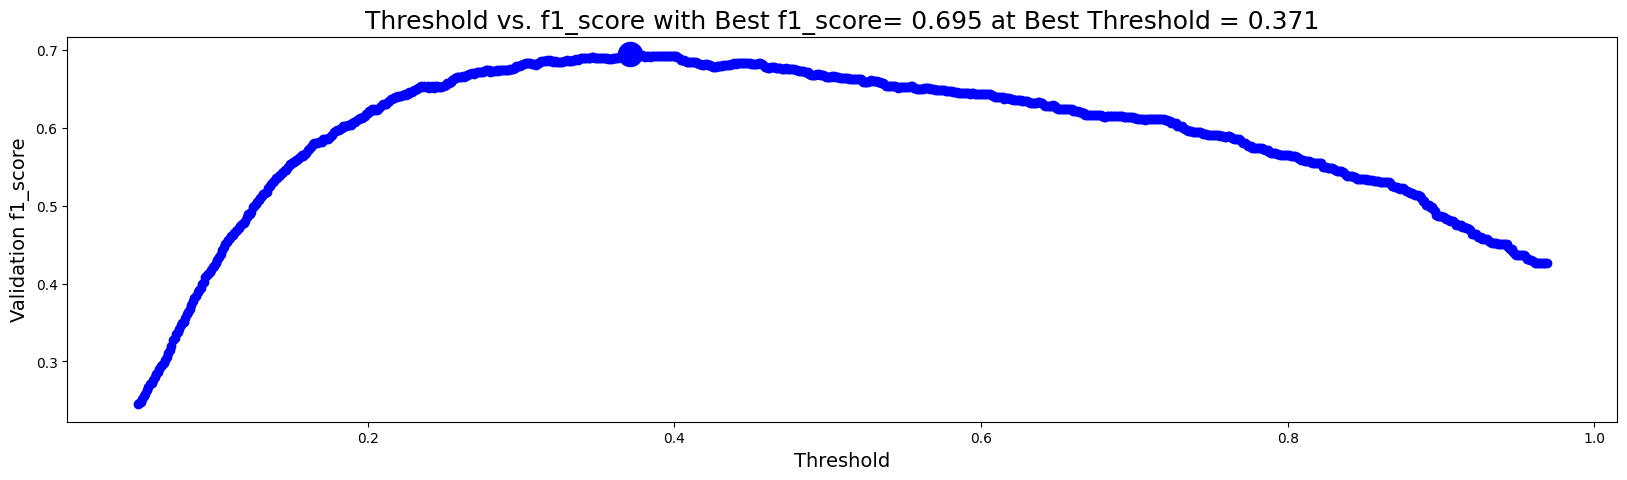

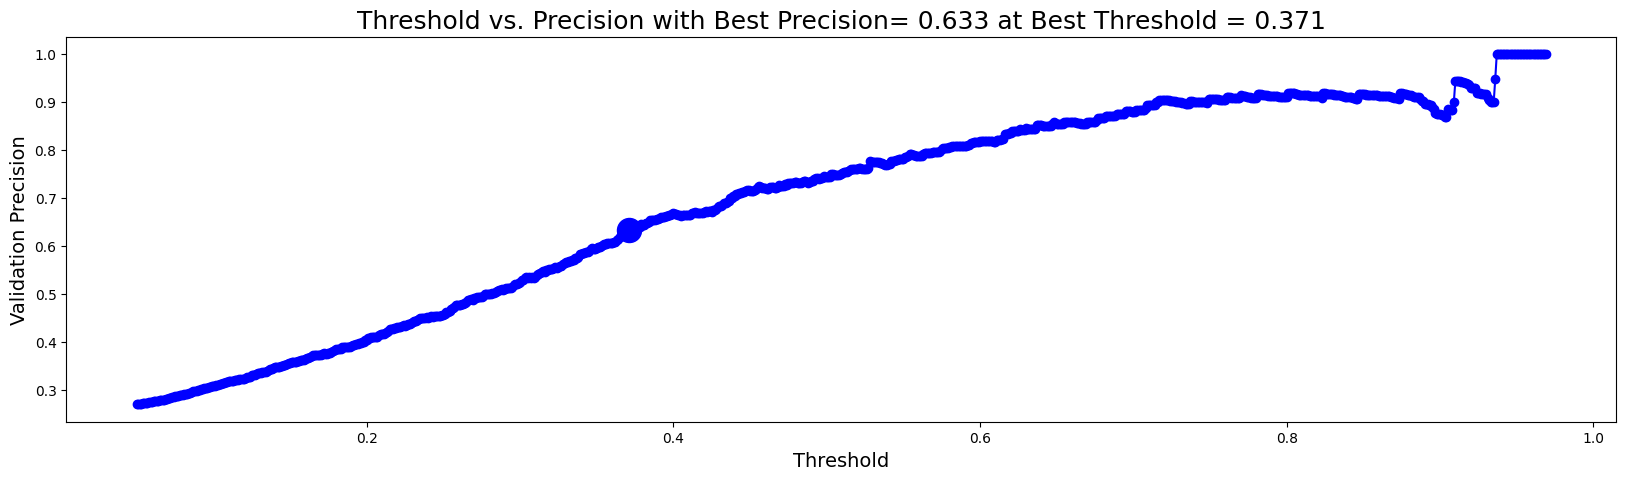

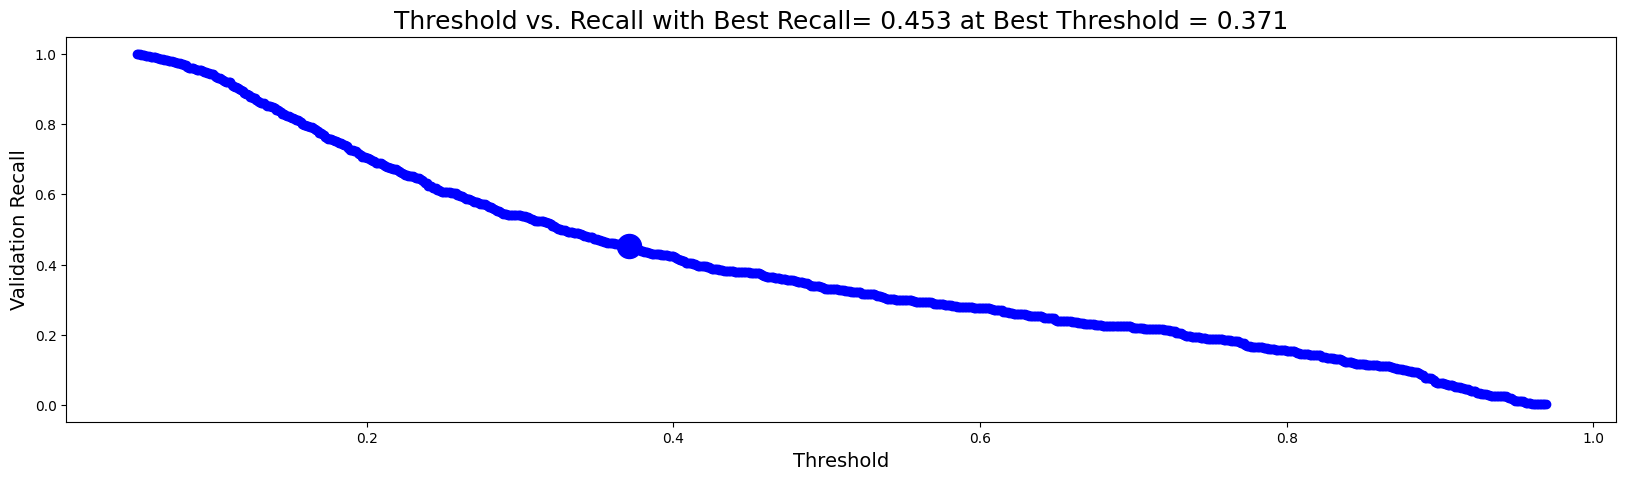

In [21]:
scores_f1_score=[]
scores_Precision=[]
scores_Recall=[]
scores = []; thresholds = []
best_f1= 0;best_score_pr= 0;best_score_rc = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    # scores.append(m)
    pr = precision_score(true.values.reshape((-1)), preds)
    rc = recall_score(true.values.reshape((-1)), preds)
    f1 = f1_score(true.values.reshape((-1)), preds,average='macro')
    m= f1_score(true.values.reshape((-1)), preds,average='macro')
    scores_f1_score.append(f1)
    scores_Precision.append(pr)
    scores_Recall.append(rc)
    thresholds.append(threshold)
    if m>best_f1:
        best_f1 = m
        best_score_pr = pr
        best_score_rc = rc
        best_threshold = threshold
scores_dict = {
            'f1_score':[scores_f1_score,best_f1],
            'Precision':[scores_Precision,best_score_pr],
            'Recall':[scores_Recall,best_score_rc]}
for i in scores_dict.keys():
  plot(scores_dict[i][0],scores_dict[i][1],i)

In [31]:
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for model in models:
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / 7

In [32]:
pred_cat = catboost_inference(X_test[columns])
pred_marks = (pred_cat> best_threshold).astype('int')

In [33]:
print(precision_score(y_test, pred_marks))
print(recall_score(y_test,pred_marks))
print(f1_score(y_test, pred_marks,average='macro'))

0.5955882352941176
0.4909090909090909
0.6958680058393343
